**Date**: 2019-02-08

**Authors**: Adam Stafford

**Purpose**: To test whether the experiment using the bidirectional LTSM from 2018-01-29 will work with only the DNA sequence without the TFBS data.

This notebook tests a naive alignment scheme that selects the first 1000 positions of a DNA sequence (add null positions to the end if a sequence is shorter than 1000). The sequences are shuffled before feeding into the neural network.

**Background**:
- The idea of this experiment is to understand how the DNA sequences contribute to the accuracy of the model from 2018-01-29. For this purpose, we run the neural network without the TFBS data.

**Experiment**:

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Load the `pickle` buffered list:

In [2]:
with open("../data/new_list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

The following cell retains only 4800 sequences, for the purpose of testing speed. It also randomly shuffles the 4800 sequences.

In [3]:
seq_record_list = seq_record_list[:4800]
from random import shuffle
shuffle(seq_record_list)

The following cell transforms the data into a format that is recognizable by the neural network model, but ignores the TFBS data.

In [4]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    for i in range(0, len(lst)):
        lst[i] = lst[i][0:4]
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = prepare_input(4320, 480, 1000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(4320, 4000), (4320, 1), (480, 4000), (480, 1)]

The following cells build a recurrent network with one bidirectional LSTM layer.

In [6]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM, Bidirectional

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
X_train_rnn = X_train.reshape(4320, 1000, 4)

In [8]:
model = Sequential()
#model.add(CuDNNLSTM(8, input_shape=(1000, 8), return_sequences=True))
model.add(CuDNNLSTM(8, input_shape=(1000, 4)))
#model.add(CuDNNLSTM(8, return_sequences=True))
#model.add(CuDNNLSTM(4, return_sequences=True))
#model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=150, batch_size=128, validation_split=0.1)

Train on 3888 samples, validate on 432 samples
Epoch 1/150
3888/3888 [==============================] - 91s 23ms/step - loss: 0.6935 - acc: 0.5255 - val_loss: 0.6910 - val_acc: 0.5509
Epoch 2/150
3888/3888 [==============================] - 3s 687us/step - loss: 0.6911 - acc: 0.5324 - val_loss: 0.6891 - val_acc: 0.5440
Epoch 3/150
3888/3888 [==============================] - 3s 668us/step - loss: 0.6886 - acc: 0.5296 - val_loss: 0.6868 - val_acc: 0.5486
Epoch 4/150
3888/3888 [==============================] - 3s 691us/step - loss: 0.6858 - acc: 0.5324 - val_loss: 0.6836 - val_acc: 0.5347
Epoch 5/150
3888/3888 [==============================] - 3s 666us/step - loss: 0.6827 - acc: 0.5332 - val_loss: 0.6806 - val_acc: 0.5417
Epoch 6/150
3888/3888 [==============================] - 3s 665us/step - loss: 0.6801 - acc: 0.5350 - val_loss: 0.6782 - val_acc: 0.5347
Epoch 7/150
3888/3888 [==============================] - 3s 670us/step - loss: 0.6784 - acc: 0.5381 - val_loss: 0.6761 - val_acc: 0

3888/3888 [==============================] - 3s 665us/step - loss: 0.6717 - acc: 0.5532 - val_loss: 0.6704 - val_acc: 0.5162
Epoch 61/150
3888/3888 [==============================] - 3s 669us/step - loss: 0.6717 - acc: 0.5553 - val_loss: 0.6707 - val_acc: 0.5486
Epoch 62/150
3888/3888 [==============================] - 3s 663us/step - loss: 0.6716 - acc: 0.5514 - val_loss: 0.6696 - val_acc: 0.5301
Epoch 63/150
3888/3888 [==============================] - 3s 709us/step - loss: 0.6713 - acc: 0.5514 - val_loss: 0.6713 - val_acc: 0.5185
Epoch 64/150
3888/3888 [==============================] - 3s 669us/step - loss: 0.6715 - acc: 0.5509 - val_loss: 0.6693 - val_acc: 0.5394
Epoch 65/150
3888/3888 [==============================] - 3s 676us/step - loss: 0.6713 - acc: 0.5484 - val_loss: 0.6675 - val_acc: 0.5370
Epoch 66/150
3888/3888 [==============================] - 3s 677us/step - loss: 0.6716 - acc: 0.5507 - val_loss: 0.6721 - val_acc: 0.5231
Epoch 67/150
3888/3888 [=======================

3888/3888 [==============================] - 3s 669us/step - loss: 0.6683 - acc: 0.5576 - val_loss: 0.6683 - val_acc: 0.5394
Epoch 120/150
3888/3888 [==============================] - 3s 669us/step - loss: 0.6676 - acc: 0.5625 - val_loss: 0.6659 - val_acc: 0.5278
Epoch 121/150
3888/3888 [==============================] - 3s 670us/step - loss: 0.6678 - acc: 0.5561 - val_loss: 0.6700 - val_acc: 0.5417
Epoch 122/150
3888/3888 [==============================] - 3s 666us/step - loss: 0.6689 - acc: 0.5558 - val_loss: 0.6683 - val_acc: 0.5579
Epoch 123/150
3888/3888 [==============================] - 3s 663us/step - loss: 0.6681 - acc: 0.5579 - val_loss: 0.6713 - val_acc: 0.5347
Epoch 124/150
3888/3888 [==============================] - 3s 672us/step - loss: 0.6678 - acc: 0.5612 - val_loss: 0.6669 - val_acc: 0.5440
Epoch 125/150
3888/3888 [==============================] - 3s 659us/step - loss: 0.6675 - acc: 0.5581 - val_loss: 0.6676 - val_acc: 0.5579
Epoch 126/150
3888/3888 [================

**Result**:

The following cell **visualizes** the training/validation accuracies and losses over each epoch.

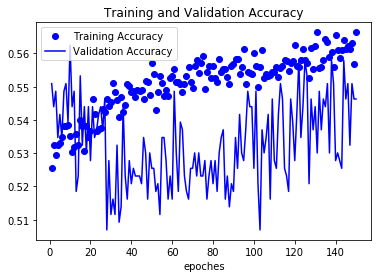

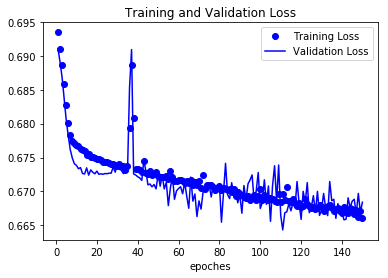

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

In [10]:
import utility
utility.save_model(model, 'models/adam_2019_02_08.json', 'models/adam_2019_02_08_weights.h5')


Save model to models/adam_2019_02_08.json


**Conclusion**:

- Using only DNA sequences and not using TFBS data, the neural network is unable to produce accurate results. It is possible that the DNA is too noisy and that the TFBS data concentrates the important information making it possible for the neural network to make accurate predictions.